In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load the dataset
file_path = 'Merged_HKKT_with_all_features.csv'
data = pd.read_csv(file_path)

# 2. Convert 'TIME' column to datetime (if applicable)
if 'TIME' in data.columns:
    data['TIME'] = pd.to_datetime(data['TIME'])

# 3. Drop unnecessary columns (non-numeric and datetime)
columns_to_drop = ['TIME', 'PRN', 'Signal Type 1', 'Signal Type 2', 'C1 Code', 'C2 Code']
data = data.drop(columns=columns_to_drop)

# 4. One-Hot Encoding for any remaining categorical columns (if required)
# Assuming no more categorical columns after drop, but you can add encoding here if needed

# 5. Separate features and target
X = data.drop(columns=['Pseudorange Residual (m)'])  # Features
y = data['Pseudorange Residual (m)']  # Target

# 6. Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Standardize/Scale the numeric features (only numeric columns)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Reshape the data for CNN input (CNN expects 3D input: [samples, timesteps, features])
# Adding an extra dimension to match CNN input requirements
X_train_cnn = np.expand_dims(X_train_scaled, axis=2)
X_test_cnn = np.expand_dims(X_test_scaled, axis=2)

# Check the shape of the data prepared for CNN
print("X_train_cnn shape:", X_train_cnn.shape)
print("X_test_cnn shape:", X_test_cnn.shape)

# Output shapes should be something like [num_samples, num_features, 1]


X_train_cnn shape: (300365, 23, 1)
X_test_cnn shape: (75092, 23, 1)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_cnn(input_shape):
    model = Sequential()
    
    # First Convolutional Layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    
    # Second Convolutional Layer
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    
    # Third Convolutional Layer
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    
    # Flattening and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))  # Dropout to prevent overfitting
    model.add(Dense(1))  # Output layer for regression
    
    # Compile the model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# 7. Create the model
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])
cnn_model = create_cnn(input_shape)

# 8. Train the CNN model
cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_data=(X_test_cnn, y_test))



Epoch 1/50


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9387/9387 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 0.4726 - val_loss: 0.0398
Epoch 2/50
9387/9387 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.0439 - val_loss: 0.0122
Epoch 3/50
9387/9387 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0278 - val_loss: 0.0094
Epoch 4/50
9387/9387 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0226 - val_loss: 0.0072
Epoch 5/50
9387/9387 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.0193 - val_loss: 0.0077
Epoch 6/50
9387/9387 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.0177 - val_loss: 0.0074
Epoch 7/50
9387/9387 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0167 - val_loss: 0.0065
Epoch 8/50
9387/9387 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0155 - val_loss: 0.0045
Epoch 9/50
9387/9387 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0148 - val_loss: 0.0076
Epoch 10/50
9387/9387 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 0.0143 - val_loss: 0.0040
Epoch 11/50
9387/9387 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0136 - val_loss: 0.0034
Epoch 12/50
9387/9387 ━━━━━━━━

NameError: name 'mean_squared_error' is not defined

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Predict the values with the trained CNN model
y_pred_cnn = cnn_model.predict(X_test_cnn)

# 10. Calculate RMS for original data (Pseudorange Residual) and CNN-predicted data
# RMS of Original Pseudorange Residual (before any modeling)
rms_original = np.sqrt(mean_squared_error(np.zeros_like(y_test), y_test))  # Comparing with 0

# RMS of CNN Predictions
rms_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))

# Improvement rate calculation
improvement_rate = (rms_original - rms_cnn) / rms_original * 100

print(f'RMS of Original: {rms_original:.4f} meters')
print(f'RMS of CNN Prediction: {rms_cnn:.4f} meters')
print(f'Improvement Rate: {improvement_rate:.2f}%')

2347/2347 ━━━━━━━━━━━━━━━━━━━━ 2s 704us/step
RMS of Original: 0.9333 meters
RMS of CNN Prediction: 0.0585 meters
Improvement Rate: 93.73%


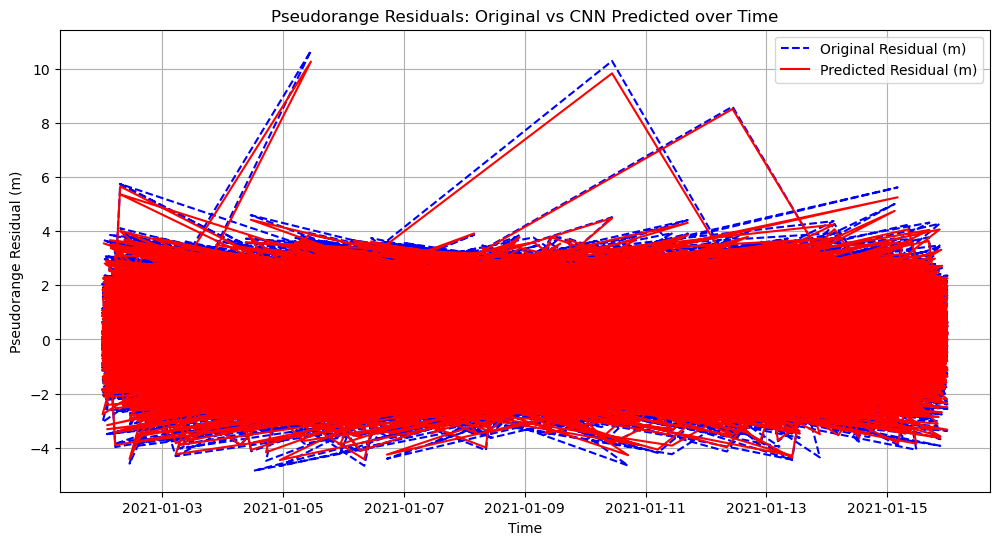

In [13]:
import matplotlib.pyplot as plt

# Ensure you have the TIME column for plotting (restore TIME column from original data)
# Re-load the original dataset with the 'TIME' column for plotting purposes
file_path = 'Merged_HKKT_with_all_features.csv'
data_with_time = pd.read_csv(file_path)

# Convert 'TIME' column to datetime (if applicable)
if 'TIME' in data_with_time.columns:
    data_with_time['TIME'] = pd.to_datetime(data_with_time['TIME'])

# Get the corresponding time values for the test set
time_test = data_with_time['TIME'].iloc[y_test.index]  # Align time with test set indices

# Ensure y_test and y_pred_cnn have the same index
y_test = y_test.reset_index(drop=True)  # Reset index to avoid misalignment
y_pred_cnn = pd.Series(y_pred_cnn.flatten(), index=y_test.index)  # Flatten predictions and align indices

# Plot the comparison between original and predicted residuals over time
plt.figure(figsize=(12, 6))

# Plot original residuals (blue, dashed)
plt.plot(time_test, y_test, label='Original Residual (m)', color='blue', linestyle='--')

# Plot predicted residuals (red)
plt.plot(time_test, y_pred_cnn, label='Predicted Residual (m)', color='red')

# Customize the plot
plt.title('Pseudorange Residuals: Original vs CNN Predicted over Time')
plt.xlabel('Time')
plt.ylabel('Pseudorange Residual (m)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
